# Local Cluster Dask Demo

_**Connect to a Local Dask Cluster on this machine and run analytics**_

This notebook works well with the `Data Science 3.0 - Python 3` kernel on SageMaker Studio Notebook Instances with the `ml.t3.large` instance (2 vCPU + 8 GiB).

---

This notebook creates a local Dask cluster and then it reads the NYC taxi dataset from an S3 bucket and illustrates how to perform basic analytics tasks and machine learning tasks. 

1. Then the cluster is scaled up to demonstrate that the time taken for the analytics task decreases as the cluster scales up. 

1. A ML task is demonstrated on the same dataset using Dask-ML. 

**It is important to stick to the exact same version of the dependencies as installed in this notebook. Any changes to anything in this notebook or cloud formation scripts would most likely cause things to break and lead to a dependency hell.**

---

---

## Contents
1. [Tasks do be done in this lab](#Tasks-do-be-done-in-this-lab)
1. [Prepare the environment](#Prepare-the-environment)
1. [Connect to the Dask Cluster](#Connect-to-the-Dask-Cluster)
1. [Exploratory Data Analytics](#Exploratory-Data-Analytics)
1. [Scale out the cluster to see if the operations become faster](#Scale-out-the-cluster-to-see-if-the-operations-become-faster)
1. [Remove anomalies and plot the distribution](#Remove-anomalies-and-plot-the-distribution)
1. [Machine Learning with Dask](#Machine-Learning-with-Dask)

_**During the course of execution of this notebook you might see errors such as `distributed.nanny - WARNING - Worker process still alive after 3.9999988555908206 seconds, killing` these are OK, especially if the thing that you asked Dask to do did indeed complete, see more here [Why did my worker die?](https://distributed.dask.org/en/stable/killed.html).**_

---

## Tasks do be done in this lab

There are 4 tasks to be done in this lab. Look for `TASK 1`, `TASK 2`, `TASK 3` and `TASK 4` in this notebook for instructions for each of the tasks. You would need to write code for each of the task and save the output requested in a file as per the instructions provided for each task.

---

## Prepare the environment

Install the exact version of Python packages that work with the Dask cluster (based on the container used by the Dask cluster, see cloud formation templates).

In [2]:
!pip install dask[complete]==2023.5.0 s3fs==2023.10.0 pyarrow==14.0.0 dask-glm==0.2.0 cytoolz==0.12.2 dask-ml==2022.5.27

  Obtaining dependency information for dask[complete]==2023.5.0 from https://files.pythonhosted.org/packages/07/93/32d3e317fec6d0fc130284f922ad9bd13d9ae0d52245e6ff6e57647e924c/dask-2023.5.0-py3-none-any.whl.metadata
  Using cached dask-2023.5.0-py3-none-any.whl.metadata (3.6 kB)
INFO: pip is looking at multiple versions of distributed to determine which version is compatible with other requirements. This could take a while.
  Obtaining dependency information for distributed>=2.4.0 from https://files.pythonhosted.org/packages/5e/6b/4a5dc8bf17a2714f53f648b6f44f1cd2ad7ab41aaaffe1c25489947c24f6/distributed-2023.10.1-py3-none-any.whl.metadata
  Using cached distributed-2023.10.1-py3-none-any.whl.metadata (3.4 kB)
  Obtaining dependency information for distributed>=2.4.0 from https://files.pythonhosted.org/packages/77/5c/3948e14bf63b5109b943eb3c175177d16f1d23e8797356984a4014252607/distributed-2023.10.0-py3-none-any.whl.metadata
  Using cached distributed-2023.10.0-py3-none-any.whl.metadata (

Install `htop` so that we can see the CPU and memory utilization because we would not be able to connect to the web portal of the local cluster (although there are ways of doing this but we would not be doing that in this class, see [ngrok](https://ngrok.com/))

In [3]:
!apt-get update
!apt-get install -y htop

Hit:1 http://security.debian.org/debian-security bullseye-security InRelease
Hit:2 http://deb.debian.org/debian bullseye InRelease
Hit:3 http://deb.debian.org/debian bullseye-updates InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
htop is already the newest version (3.0.5-7).
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.


In [4]:
!python -m pip install "dask[complete]"  --upgrade
!pip install "dask[dataframe]"

  Obtaining dependency information for dask[complete] from https://files.pythonhosted.org/packages/9a/83/e11961f175a6aff67a46dcf4f4f4eba709678b5a351bc4d2c913d9eb39b9/dask-2023.11.0-py3-none-any.whl.metadata
  Using cached dask-2023.11.0-py3-none-any.whl.metadata (3.7 kB)
  Obtaining dependency information for distributed==2023.11.0 from https://files.pythonhosted.org/packages/77/a6/34c16487b659de5b42942f13949af8a03c3ea0208f0cd6bcf2cd576e2c28/distributed-2023.11.0-py3-none-any.whl.metadata
  Using cached distributed-2023.11.0-py3-none-any.whl.metadata (3.4 kB)
Using cached dask-2023.11.0-py3-none-any.whl (1.2 MB)
Using cached distributed-2023.11.0-py3-none-any.whl (1.0 MB)
  Attempting uninstall: dask
    Found existing installation: dask 2023.5.0
    Uninstalling dask-2023.5.0:
      Successfully uninstalled dask-2023.5.0
  Attempting uninstall: distributed
    Found existing installation: distributed 2023.5.0
    Uninstalling distributed-2023.5.0:
      Successfully uninstalled distri

In [5]:
# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [6]:
import os
import dask
import s3fs
import time
import joblib
import distributed
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
from dask.distributed import Client
from dask.distributed import LocalCluster
from sklearn.metrics import mean_squared_error
from dask.distributed import performance_report
from dask_ml.linear_model import LinearRegression
from dask_ml.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 14.0.0. Please consider upgrading.
  warnings.warn(


---

## Connect to the Dask Cluster

With the right packages installed, now create and connect to the Dask cluster. Any Dask operations we do after that are automatically done at the _local_ cluster.

As created, the Dask cluster has one _scheduler task_ and as many _worker tasks_ as there are vCPUs on this instance.

In [7]:
# enable this client for fargate distributed cluster testing
cluster = LocalCluster()
client = Client(cluster)

In [8]:
client.cluster

Link to this cluster, we will not be able to access this, but if you run this notebook on your laptop you will be able to access it.

In [9]:
cluster.dashboard_link

'http://127.0.0.1:8787/status'

Use the `get_logs` function to access the logs of this cluster. Each task also has its web page.

In [10]:
cluster.get_logs()

{'Cluster': '',
 'Scheduler': "2023-11-14 19:18:17,980 - distributed.scheduler - INFO - Receive client connection: Client-90fe172d-8322-11ee-8284-e3296a9ed675\n2023-11-14 19:18:17,923 - distributed.scheduler - INFO - Starting worker compute stream, tcp://127.0.0.1:44925\n2023-11-14 19:18:17,923 - distributed.scheduler - INFO - Register worker <WorkerState 'tcp://127.0.0.1:44925', name: 1, status: running, memory: 0, processing: 0>\n2023-11-14 19:18:17,894 - distributed.scheduler - INFO - Starting worker compute stream, tcp://127.0.0.1:43797\n2023-11-14 19:18:17,893 - distributed.scheduler - INFO - Register worker <WorkerState 'tcp://127.0.0.1:43797', name: 0, status: running, memory: 0, processing: 0>\n2023-11-14 19:18:16,544 - distributed.scheduler - INFO - Registering Worker plugin shuffle\n2023-11-14 19:18:16,544 - distributed.scheduler - INFO -   dashboard at:  http://127.0.0.1:8787/status\n2023-11-14 19:18:16,544 - distributed.scheduler - INFO -   Scheduler at:     tcp://127.0.0.1:42785\n2023-11-14 19:18:16,540 - distributed.scheduler - INFO - State start",
 'tcp://127.0.0.1:43797': '2023-11-14 19:18:17,897 - distributed.worker - INFO - -------------------------------------------------\n2023-11-14 19:18:17,897 - distributed.worker - INFO -         Registered to:      tcp://127.0.0.1:42785\n2023-11-14 19:18:17,896 - distributed.worker - INFO - Starting Worker plugin shuffle\n2023-11-14 19:18:17,428 - distributed.worker - INFO - -------------------------------------------------\n2023-11-14 19:18:17,428 - distributed.worker - INFO -       Local Directory: /tmp/dask-scratch-space/worker-ds82ivqi\n2023-11-14 19:18:17,428 - distributed.worker - INFO -                Memory:                   3.20 GiB\n2023-11-14 19:18:17,428 - distributed.worker - INFO -               Threads:                          1\n2023-11-14 19:18:17,428 - distributed.worker - INFO - -------------------------------------------------\n2023-11-14 19:18:17,428 - distributed.worker - INFO - Waiting to connect to:      tcp://127.0.0.1:42785\n2023-11-14 19:18:17,428 - distributed.worker - INFO -          dashboard at:            127.0.0.1:41797\n2023-11-14 19:18:17,428 - distributed.worker - INFO -           Worker name:                          0\n2023-11-14 19:18:17,428 - distributed.worker - INFO -          Listening to:      tcp://127.0.0.1:43797\n2023-11-14 19:18:17,428 - distributed.worker - INFO -       Start worker at:      tcp://127.0.0.1:43797',
 'tcp://127.0.0.1:44925': '2023-11-14 19:18:17,925 - distributed.worker - INFO - -------------------------------------------------\n2023-11-14 19:18:17,924 - distributed.worker - INFO -         Registered to:      tcp://127.0.0.1:42785\n2023-11-14 19:18:17,924 - distributed.worker - INFO - Starting Worker plugin shuffle\n2023-11-14 19:18:17,486 - distributed.worker - INFO - -------------------------------------------------\n2023-11-14 19:18:17,486 - distributed.worker - INFO -       Local Directory: /tmp/dask-scratch-space/worker-7t8fbotr\n2023-11-14 19:18:17,486 - distributed.worker - INFO -                Memory:                   3.20 GiB\n2023-11-14 19:18:17,486 - distributed.worker - INFO -               Threads:                          1\n2023-11-14 19:18:17,486 - distributed.worker - INFO - -------------------------------------------------\n2023-11-14 19:18:17,486 - distributed.worker - INFO - Waiting to connect to:      tcp://127.0.0.1:42785\n2023-11-14 19:18:17,486 - distributed.worker - INFO -          dashboard at:            127.0.0.1:42499\n2023-11-14 19:18:17,486 - distributed.worker - INFO -           Worker name:                          1\n2023-11-14 19:18:17,486 - distributed.worker - INFO -          Listening to:      tcp://127.0.0.1:44925\n2023-11-14 19:18:17,486 - distributed.worker - INFO -       Start worker at:      tcp://127.0.0.1:44925'}

After initiating the scale up of cluster give it about 5 minutes for the additional compute to become available. Note the CPU and memory resources now available to the cluster.This cluster now has 6 works with 12 cores and 24GB RAM (recall we had 2 vCPUs and 4 GB per worker).

---

## Exploratory Data Analytics

We will be reading the new york taxi dataset for 2021 and running some analytics on it.

1. Note the similarity between the Dask dataframe API and the Pandas API.

1. Note that we are able to read all the files in one call using the `*` wildcard character.

Since this is a local cluster we will not be reading the entire year's worth of file, but just for one month.

### [TASK 1] Read the files for the last 3 months of the year

The demo in the class only read the file for December, for this task we need to read the files for the last **3 months** i.e. October, November and December.

In [11]:
# read the data directly from S3, data is accessible with anonymous credentials
months = "1*"
df = dd.read_parquet(f's3://nyc-tlc/trip data/yellow_tripdata_2021-{months}.parquet',                 
                     parse_dates=['tpep_pickup_datetime','tpep_dropoff_datetime'])

The data frame is lazy loaded and is automatically partitioned (you can control this by specifying the `blocksize` parameter, see [read_csv](https://docs.dask.org/en/stable/generated/dask.dataframe.read_csv.html)).

In [12]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
npartitions=3,,,,,,,,,,,,,,,,,,,
,int64,datetime64[ns],datetime64[ns],float64,float64,float64,object,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


How many rows did we read? Well, the `shape` attribute does not give us the number of rows because this dataframe is not yet been loaded into the memory only a DAG has been created for reading it. `shape` will tell us the number of columns, to get the number of rows we will have to do a `len`. The data contains about ~31 million rows.

In [13]:
df.shape

(Delayed('int-1accd42b-18b7-4856-a417-64dbf3223f49'), 19)

In [14]:
%%time
print(f"{len(df):,}") 

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 14.0.0. Please consider upgrading.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 14.0.0. Please consider upgrading.
  warnings.warn(


10,150,822
CPU times: user 236 ms, sys: 20.6 ms, total: 257 ms
Wall time: 2.34 s


Let's find out average trip distance and total count.

In [15]:
%%time
start = time.perf_counter()
results = df[['trip_distance', 'total_amount']].mean().compute().to_frame().reset_index()
end = time.perf_counter()

# set column names for the resulting dataframe
results.columns = ["feature", "mean"]
results

CPU times: user 169 ms, sys: 21.4 ms, total: 190 ms
Wall time: 1.12 s


,feature,mean
0,trip_distance,7.251318
1,total_amount,20.606048


---


## Scale out the cluster to see if the operations become faster

It would make sense to say that if we double the size of the cluster then the time taken for the analytics task should reduce. Let us do that and see if it happens. We look at the cluster web portal to see that the number of tasks have increased.


In [16]:
cluster.scale(8)  # Sets the number of workers 

cluster.adapt(minimum=1, maximum=8)  # Allows the cluster to auto scale when tasks are computed

In [17]:
client.cluster

In [18]:
%%time
start = time.perf_counter()
results = df[['trip_distance', 'total_amount']].mean().compute().to_frame().reset_index()
end = time.perf_counter()

# set column names for the resulting dataframe
results.columns = ["feature", "mean"]
results

CPU times: user 467 ms, sys: 25.9 ms, total: 493 ms
Wall time: 3.19 s


,feature,mean
0,trip_distance,7.251318
1,total_amount,20.606048


**_As you can see, scaling out on the same instance does not help much because we were already at 100% CPU utilization on all the CPUs prior to scaling out. This is different from what we saw on a distributed cluster where scaling out truly made a difference._**

Here is a screenshot from htop about the memory and CPU utilization from all the tasks.



![](img/dask-ui-local-1.png)

#### Count the total trip distance and count for each vendor

In [19]:
%%time
df.groupby('VendorID').agg({'passenger_count':'count', 'trip_distance': 'sum'}).astype(int).compute()

2023-11-14 19:18:36,185 - distributed.core - INFO - Connection to tcp://127.0.0.1:42785 has been closed.
2023-11-14 19:18:36,187 - distributed.core - INFO - Connection to tcp://127.0.0.1:42785 has been closed.
2023-11-14 19:18:36,190 - distributed.core - INFO - Connection to tcp://127.0.0.1:42785 has been closed.
2023-11-14 19:18:36,203 - distributed.core - INFO - Connection to tcp://127.0.0.1:42785 has been closed.
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 14.0.0. Please consider upgrading.
  warnings.warn(
2023-11-14 19:18:36,358 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:39581'.
2023-11-14 19:18:36,361 - distributed.worker - ERROR - Scheduler was unaware of this worker 'tcp://127.0.0.1:39581'. Shutting down.
2023-11-14 19:18:39,422 - distributed.nanny - WARNING - Worker process still alive after 3.19999877

CPU times: user 440 ms, sys: 77.3 ms, total: 517 ms
Wall time: 3.27 s


,passenger_count,trip_distance
VendorID,,
1,3031757,9641521
2,6752842,63795736
6,0,169316
5,0,265


2023-11-14 19:18:40,145 - distributed.core - INFO - Connection to tcp://127.0.0.1:42785 has been closed.


### Selecting top 10 rides based on fare amount

In [20]:
%%time
most_paid_rides_dask = df[['PULocationID', 'fare_amount']].nlargest(10, "fare_amount").compute()

CPU times: user 185 ms, sys: 32.6 ms, total: 218 ms
Wall time: 1.44 s


In [21]:
most_paid_rides_dask

,PULocationID,fare_amount
2614048,143,3009.0
1348192,183,1217.0
1555201,132,1043.5
1402852,265,1025.0
676067,265,984.0
676066,265,980.0
2689554,265,950.0
2817275,191,950.0
2817276,191,950.0
2966119,19,950.0


Clearly these represent anomalies in the data, a fare amount of hundereds of thousdands of dollars!!!!

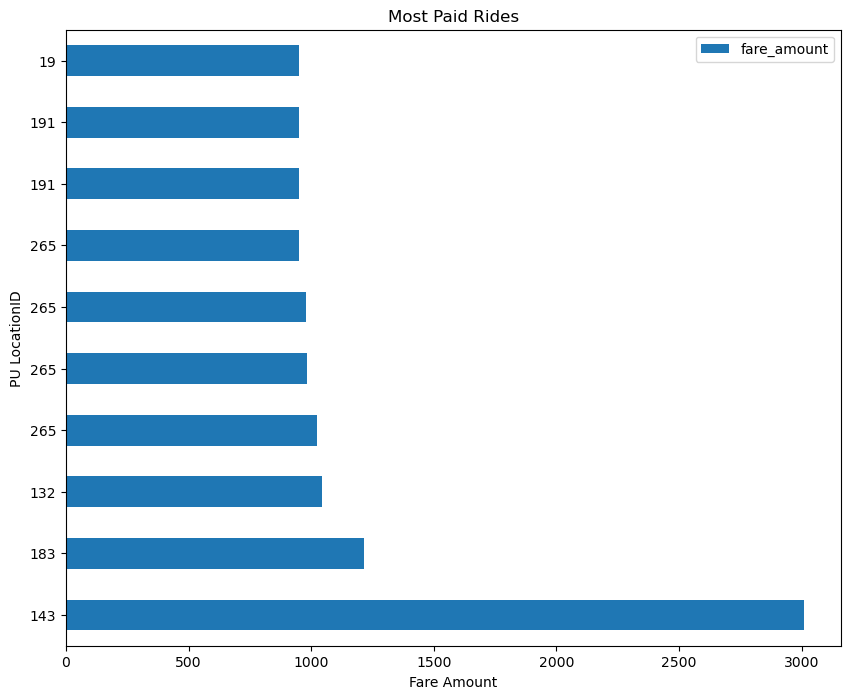

In [22]:
## Visualizing most paid rides through Barplot
most_paid_rides_dask.set_index('PULocationID').plot(kind='barh',stacked=False, figsize=[10,8], legend=True)

plt.title('Most Paid Rides')
plt.xlabel('Fare Amount')
plt.ylabel('PU LocationID')
plt.show()

#### Visualizing trip distance through Barplot

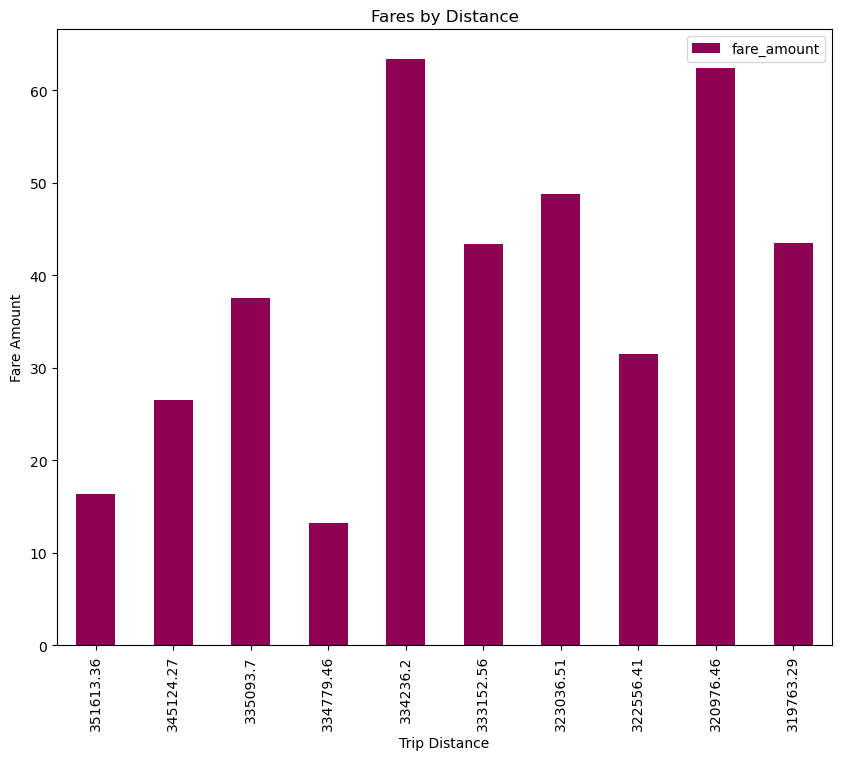

2023-11-14 19:18:47,142 - distributed.core - INFO - Connection to tcp://127.0.0.1:42785 has been closed.


In [23]:
most_paid_rides_dask2 = df[['trip_distance', 'fare_amount']].nlargest(10, "trip_distance").compute()
most_paid_rides_dask2.set_index('trip_distance').plot(kind='bar', colormap='PiYG', stacked=False, figsize=[10,8], legend=True)

plt.title('Fares by Distance')
plt.xlabel('Trip Distance')
plt.ylabel('Fare Amount')
plt.show()

### Let's view the quantile distribution, something we should have done earlier

Clearly, anything about the 99th percentile as an anomaly.

We can save the complete details of what Dask did for running our code using the `performance_report` function, see [diagnosing performance](https://distributed.dask.org/en/stable/diagnosing-performance.html). See example below. 

**_If your task completes and you get the results then you can ignore exceptions from individual Dask tasks, Dask will take care of restarting any failed tasks for you._**

In [24]:
%%time
with performance_report(filename="dask-report-quantiles.html"):
    df_quantiles = df[['trip_distance', 'fare_amount']].quantile([0.25, 0.5, 0.75, 0.95, 0.99, 1]).compute().reset_index()
    print(df_quantiles)

   index  trip_distance  fare_amount
0   0.25           1.10          7.0
1   0.50           1.85         10.0
2   0.75           3.44         16.0
3   0.95          13.63         47.5
4   0.99          19.97         58.5
5   1.00      351613.36       3009.0
CPU times: user 856 ms, sys: 58.4 ms, total: 915 ms
Wall time: 2.87 s


---

## [TASK 2] Remove anomalies and plot the distribution

We remove the anomalies from the `trip_distance` and `fare_amount` fields and plot their distributions using `matplotlib` as a histogram. 

1. To remove the anomalies we keep all values that are `>= 0` and `<= 99th percentile`.
1. The 99th percentile values for `fare_amount` and `trip_distance` should be saved in a file called `q99.csv` which should look like (numbers here are just example)
    ```
    trip_distance,fare_amount
    12.34,5.23
    ```
1. The name of plot file for `fare_amount` should be `fare_amount.png`.
1. The name of plot file for `trip_distance` should be `trip_distance.png`.


In [25]:
# Keep values that are >= 0 and <= 99th percentile in the trip_distance and fare_amount fields
trip_99p = df['trip_distance'].quantile(0.99).compute() #trip_distance
fare_99p = df['fare_amount'].quantile(0.99).compute() #fare_amount

# Filter out anomalies
no_anomalies = df[(df['trip_distance'] <= trip_99p) & (df['trip_distance'] >= 0) & (df['fare_amount'] <= fare_99p) & (df['fare_amount'] >= 0)]

In [26]:
# Get 99th percentile values for fare_amount and trip_distance in pandas df
df_99p = pd.DataFrame({
    'trip_distance': [trip_99p],
    'fare_amount': [fare_99p]
})

# Explort to csv
df_99p.to_csv('q99.csv')

In [27]:
# Compute filtered
filtered = no_anomalies.compute()

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 14.0.0. Please consider upgrading.
  warnings.warn(
2023-11-14 19:19:17,210 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.39 GiB -- Worker memory limit: 3.20 GiB
2023-11-14 19:19:17,869 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 2.58 GiB -- Worker memory limit: 3.20 GiB
2023-11-14 19:19:18,530 - distributed.core - INFO - Connection to tcp://127.0.0.1:42785 has been closed.
2023-11-14 19:19:19,660 - distributed.worker.memory - WARNING - Worker is at 74% memory usage. Resuming worker. Process memory: 2.40 GiB -- Worker memor

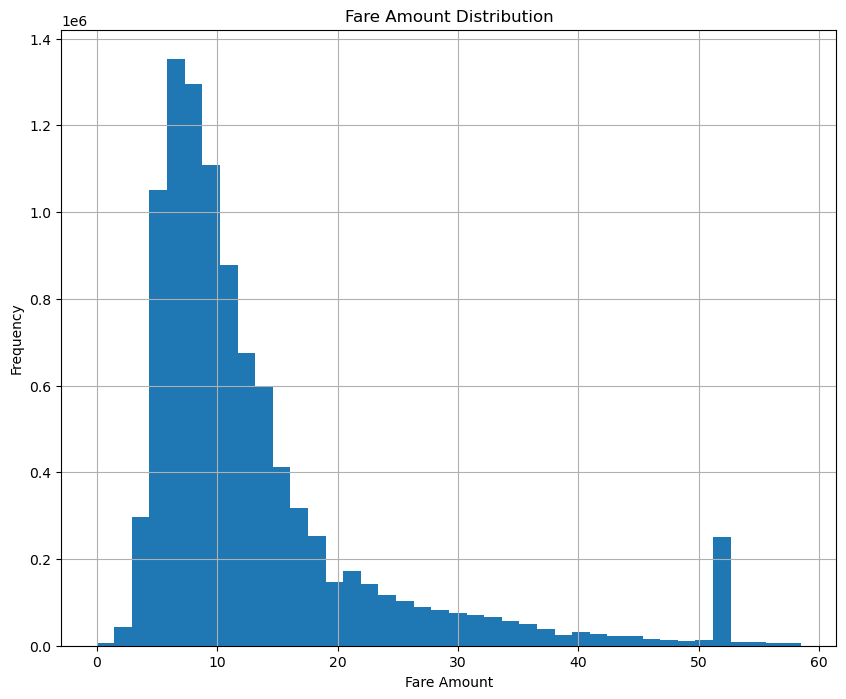

In [32]:
# Plot fare_amount
plt.figure(figsize=(10, 8)) #size
filtered['fare_amount'].hist(bins=40) #define bins
plt.title('Fare Amount Distribution') #distribution title
plt.xlabel('Fare Amount') #label x
plt.ylabel('Frequency') #label y
plt.savefig('fare_amount.png') #save as fare_amount.png

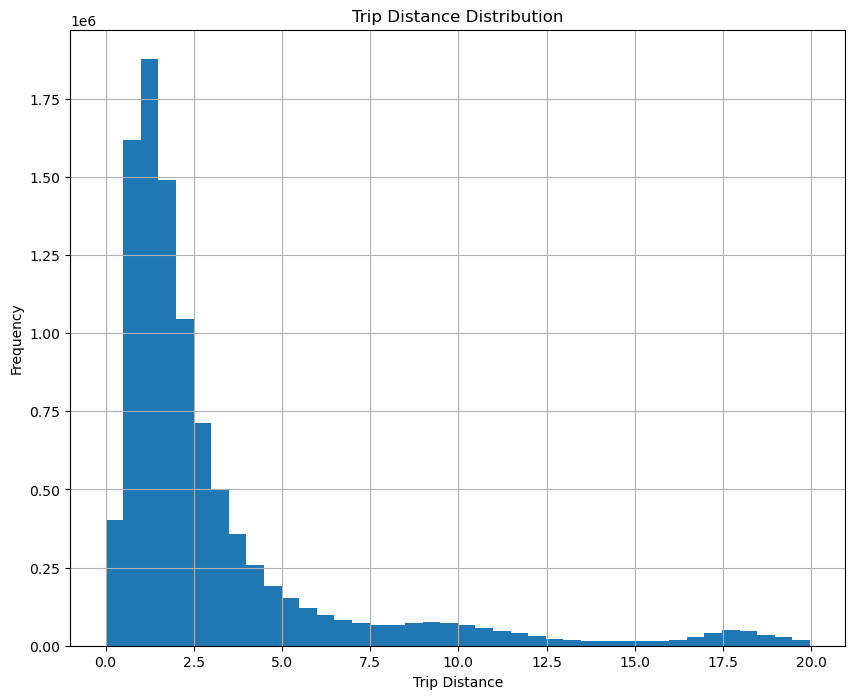

In [33]:
# Plot fare_amount
plt.figure(figsize=(10, 8)) #size
filtered['trip_distance'].hist(bins=40) #define bins
plt.title('Trip Distance Distribution') #distribution title
plt.xlabel('Trip Distance') #label x
plt.ylabel('Frequency') #label y
plt.savefig('trip_distance.png') #save as trip_distance.png

---

## Machine Learning with Dask

We create a derived field called `trip_duration` which is the difference between `tpep_dropoff_datetime` and `tpep_pickup_datetime` (note that both these fields were read as datetime when the Dask dataframe was initially created from the CSV files) and train a linear regression model to predict it based on `passenger_count`,`trip_distance`,`fare_amount` and `total_amount`. 

**_Note that the primary objective here is to show how a Dask cluster can be used to train an ML model rather than training the best model possible._**

In [50]:
# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [2]:
import os
import dask
import s3fs
import time
import joblib
import distributed
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
from dask.distributed import Client
from dask.distributed import LocalCluster
from sklearn.metrics import mean_squared_error
from dask.distributed import performance_report
from dask_ml.linear_model import LinearRegression
from dask_ml.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 14.0.0. Please consider upgrading.
  warnings.warn(


In [3]:
# enable this client for fargate distributed cluster testing
cluster = LocalCluster()
client = Client(cluster)

In [4]:
client.cluster

In [5]:
# read the data directly from S3
months = "1*"
df = dd.read_parquet(f's3://nyc-tlc/trip data/yellow_tripdata_2021-{months}.parquet',
                 parse_dates=['tpep_pickup_datetime','tpep_dropoff_datetime'])

In [6]:
df['trip_duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']

In [7]:
df['trip_duration'].head()

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 14.0.0. Please consider upgrading.
  warnings.warn(
2023-11-14 19:54:12,433 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.25 GiB -- Worker memory limit: 3.20 GiB


0   0 days 00:45:39
1   0 days 00:24:18
2   0 days 00:22:45
3   0 days 00:39:02
4   0 days 00:22:36
Name: trip_duration, dtype: timedelta64[ns]

Convert the trip duration to hours.

In [8]:

df['trip_duration'] = df['trip_duration']/np.timedelta64(1,'D')
df['trip_duration'] = df['trip_duration'] * 24
df['trip_duration']

Dask Series Structure:
npartitions=3
    float64
        ...
        ...
        ...
Name: trip_duration, dtype: float64
Dask Name: getitem, 12 graph layers

In [9]:
df['trip_duration'].head()

0    0.760833
1    0.405000
2    0.379167
3    0.650556
4    0.376667
Name: trip_duration, dtype: float64

In [10]:
%%time
df.head()

CPU times: user 401 ms, sys: 32.5 ms, total: 434 ms
Wall time: 3.27 s


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration
0,1,2021-10-01 00:25:56,2021-10-01 01:11:35,1.0,7.40,1.0,Y,140,36,1,33.0,3.0,0.5,4.00,0.0,0.3,40.80,2.5,0.0,0.760833
1,1,2021-10-01 00:17:13,2021-10-01 00:41:31,1.0,14.10,1.0,N,209,94,2,39.0,3.0,0.5,0.00,0.0,0.3,42.80,2.5,0.0,0.405000
2,2,2021-10-01 00:25:22,2021-10-01 00:48:07,2.0,5.64,1.0,N,238,107,1,20.0,0.5,0.5,4.76,0.0,0.3,28.56,2.5,0.0,0.379167
3,1,2021-10-01 00:17:28,2021-10-01 00:56:30,0.0,5.50,1.0,N,48,179,1,27.5,3.0,0.5,3.00,0.0,0.3,34.30,2.5,0.0,0.650556
4,1,2021-10-01 00:09:30,2021-10-01 00:32:06,1.0,3.70,1.0,N,79,25,2,17.5,3.0,0.5,0.00,0.0,0.3,21.30,2.5,0.0,0.376667


Replace all NAs with 0

In [11]:
df = df.fillna(value=0)

In [12]:
df.shape

(Delayed('int-8c0834ce-0573-40c0-906f-ac194ce4f784'), 20)

In [13]:
len(df)

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 14.0.0. Please consider upgrading.
  warnings.warn(
2023-11-14 19:54:29,102 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.28 GiB -- Worker memory limit: 3.20 GiB


10150822

**_The next would be to one-hot encode the categroical variables but we run into Dask related errors which so for now we will skip the categorical variables._**

Setup the features and the target variable and then do a train test split. We get the data we need as a pandas dataframe, this should not be needed we should be able to train with the lazy loaded dataframe. We run into errors with the tasks not finding `_sqrt` function, most likely because of using an older version of one of the packages. Updating the packages would mean using a newer container for the Dask scheduler and container, I tried that but that created other problems and for the purpose of this notebook I decided to stick to getting the data locally into this notebook and then relying on Dask to distribute it again, know that this is not how it will work in production.

In [14]:
#x = df[['VendorID','RatecodeID','PULocationID','DOLocationID','passenger_count','trip_distance','fare_amount','total_amount']]
x = df[['passenger_count','trip_distance','fare_amount','total_amount']].compute()

2023-11-14 19:56:16,075 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.27 GiB -- Worker memory limit: 3.20 GiB
2023-11-14 19:56:16,315 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.25 GiB -- Worker memory limit: 3.20 GiB
2023-11-14 19:56:20,802 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-11-14 19:56:22,117 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-11-14 19:56:23,736 - distribu

In [15]:
y = df['trip_duration'].compute()

2023-11-14 19:57:13,477 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.27 GiB -- Worker memory limit: 3.20 GiB
2023-11-14 19:57:14,402 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.36 GiB -- Worker memory limit: 3.20 GiB
2023-11-14 19:57:16,375 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-11-14 19:57:17,080 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-11-14 19:57:17,866 - distribu

In [22]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=1, shuffle=True)

In [23]:
len(X_train), len(X_test), len(y_train), len(y_test)

(9135739, 1015083, 9135739, 1015083)

The Dask API does not support dataframe so extract the array as `values`.

In [24]:
training_x = X_train.values
training_y = y_train.values

In [25]:
training_x

array([[ 1.  ,  1.74,  8.5 , 13.57],
       [ 1.  , 10.91, 31.5 , 56.03],
       [ 0.  ,  0.48, 11.45, 15.  ],
       ...,
       [ 3.  ,  2.74, 12.  , 18.2 ],
       [ 1.  ,  0.58,  6.5 , 12.96],
       [ 1.  ,  3.24, 17.  , 24.36]])

In [26]:
testing_x = X_test.values
testing_y = y_test.values

In [27]:
def rmse(preds, actuals):
    error = mean_squared_error(actuals, preds)
    rmse = np.sqrt(error)
    return rmse


## [TASK 3] Train the linear regression model on the Dask cluster.

Train the linear regression model and save the performance report in a file called `dask-report-lr.html`.

In [29]:
with performance_report(filename="dask-report-lr.html"):
    # your linear regression code goes here
    model = LinearRegression()
    model.fit(training_x, training_y)

/opt/conda/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 418.20 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Prediction and RMSE.

In [30]:
preds = model.predict(testing_x)
preds

array([0.22150827, 0.18413431, 0.24043522, ..., 0.28402319, 0.21525681,
       0.17173759])

In [31]:
testing_y

array([0.17027778, 0.09      , 0.15944444, ..., 0.33027778, 0.13472222,
       0.07722222])

In [32]:
rmse_val = rmse(preds, testing_y)
rmse_val

1.0547255641962696

### [Task 4] Save RMSE to a local file

The filename should be `rmse.txt`. the contents of the file should be (as an example) `rmse=3.456`.

In [33]:
path = 'rmse.txt'

# Write the RMSE value to a file
with open(path, 'w') as file:
    file.write(f'rmse={rmse_val}')